# Linear Model Experiment 
---
Goal : 
* Trying linear model approach to identify best performing model given current dataset
* Use feature scaling (standard scaler) + One Hot Encoding
* Still not using Product category clustering 
* Might be able to improve performance by improving distribution on working day interval
Reference : https://www.kaggle.com/faressayah/linear-regression-house-price-prediction


04 July 2021

In [2]:
# Basic 
import sys
import json

# Warning problems in notebook
import warnings
warnings.filterwarnings('ignore')

# Profiling process
from tqdm import tqdm

# Reporting result
from IPython.display import display

# Math
import numpy as np
import scipy as sp
import pandas as pd

# Statistics
from statsmodels.stats.outliers_influence import variance_inflation_factor

# SQL Engine
import psycopg2
import pandas as pd
from sqlalchemy import create_engine

# Visualization
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns

# Reporting result
import sweetviz as sv
from dataprep.eda import create_report, plot, plot_missing, plot_correlation

# Metrics
from sklearn import metrics

# Learning Helper | Modelling
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LinearRegression, PoissonRegressor, RANSACRegressor

# from lazypredict.Supervised import LazyRegressor

# CLustering
from sklearn.cluster import KMeans

# Dimension reductionality
from sklearn.decomposition import PCA

In [3]:
# Progress apply for pandas
tqdm.pandas()

# Seaborn color palette
sns.set_palette('husl')

# Inline matplotlib
%matplotlib inline

# Plotting pretty figures and avoid blurry images
%config InlineBackend.figure_format = 'retina'

# Larger scale for plots in notebooks
sns.set_context('notebook')

# Showing all output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
# Calculating multicollinearity
def calc_vif(X):
    # Calculating VIF
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

# Saving model 
def save_model(model, name="model"):
    pickle.dump(model, open(f"../bin/{name}", "wb"))
    
# Scaling
def scale(data,cols,transformer = StandardScaler()):
    new_data = data.copy()
    pbar_scale = tqdm(cols)
    for i in pbar_scale:
        pbar_scale.set_description(f"Processing : {i}")
        new_data[i] = transformer.fit_transform(new_data[i].values.reshape(-1,1))
    return new_data 

# Encode
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode 
    @return a DataFrame with one-hot encoding
    """
    new_cols = []
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        for col in dummies.columns:
            new_cols.append(col)
    return df, new_cols

In [5]:
# === Load data ===

## EDIT THIS CODE
# =====================
filename = "../data/processed/dataset-supervised-processed.pkl"
# =====================

target = "wd_actual_delivery_interval"

df = pd.read_pickle(filename)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90183 entries, 0 to 95126
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   total_unique_item                90183 non-null  int64  
 1   product_volume_cm3_per_item      90183 non-null  float64
 2   product_weight_g_per_item        90183 non-null  float64
 3   order_day_of_week                90183 non-null  int64  
 4   order_day_of_month               90183 non-null  int64  
 5   order_quarter                    90183 non-null  float64
 6   order_is_weekend                 90183 non-null  bool   
 7   order_hour                       90183 non-null  int64  
 8   order_daytime                    90183 non-null  object 
 9   order_approved_day_of_week       90183 non-null  float64
 10  order_approved_day_of_month      90183 non-null  float64
 11  order_approved_quarter           90183 non-null  float64
 12  order_approved_is_

<AxesSubplot:xlabel='wd_actual_delivery_interval'>

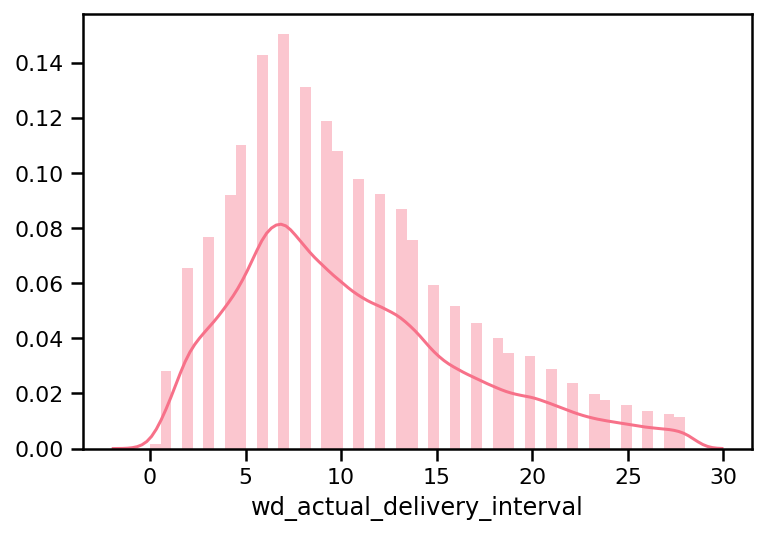

In [6]:
# === Show distribution of target value ===
sns.distplot(df[target])

In [7]:
# Drop item with missing data
df = df.dropna()
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90183 entries, 0 to 95126
Data columns (total 35 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   total_unique_item                90183 non-null  int64  
 1   product_volume_cm3_per_item      90183 non-null  float64
 2   product_weight_g_per_item        90183 non-null  float64
 3   order_day_of_week                90183 non-null  int64  
 4   order_day_of_month               90183 non-null  int64  
 5   order_quarter                    90183 non-null  float64
 6   order_is_weekend                 90183 non-null  bool   
 7   order_hour                       90183 non-null  int64  
 8   order_daytime                    90183 non-null  object 
 9   order_approved_day_of_week       90183 non-null  float64
 10  order_approved_day_of_month      90183 non-null  float64
 11  order_approved_quarter           90183 non-null  float64
 12  order_approved_is_

## Feature Selection

In [8]:
df['is_same_area'] = df['is_same_area'].astype('int')

In [9]:
to_drop = [
    "wd_estimated_delivery_interval"
]

,wd_actual_delivery_interval
wd_actual_delivery_interval,1.000000
log_shipping_cost,0.211363
cbrt_original_distance,0.203099
log_shipping_distance,0.174387
wd_pickup_limit_interval,0.126716
log_delivering_distance,0.126126
log_aov,0.094688
log_total_price,0.091602
log_product_weight_g_per_item,0.089557
log_package_weight_g,0.086532


,variables,VIF
12,log_package_volume_cm3,7493791.979327
14,log_product_volume_cm3_per_item,7369527.140649
13,log_package_weight_g,4403014.833914
15,log_product_weight_g_per_item,4308935.729853
4,order_approved_quarter,882.719566
2,order_quarter,831.040353
8,log_shipping_cost,91.121793
10,log_shipping_distance,89.353922
5,pickup_limit_quarter,55.379863
9,cbrt_original_distance,50.242138


<Figure size 864x576 with 0 Axes>

<AxesSubplot:>

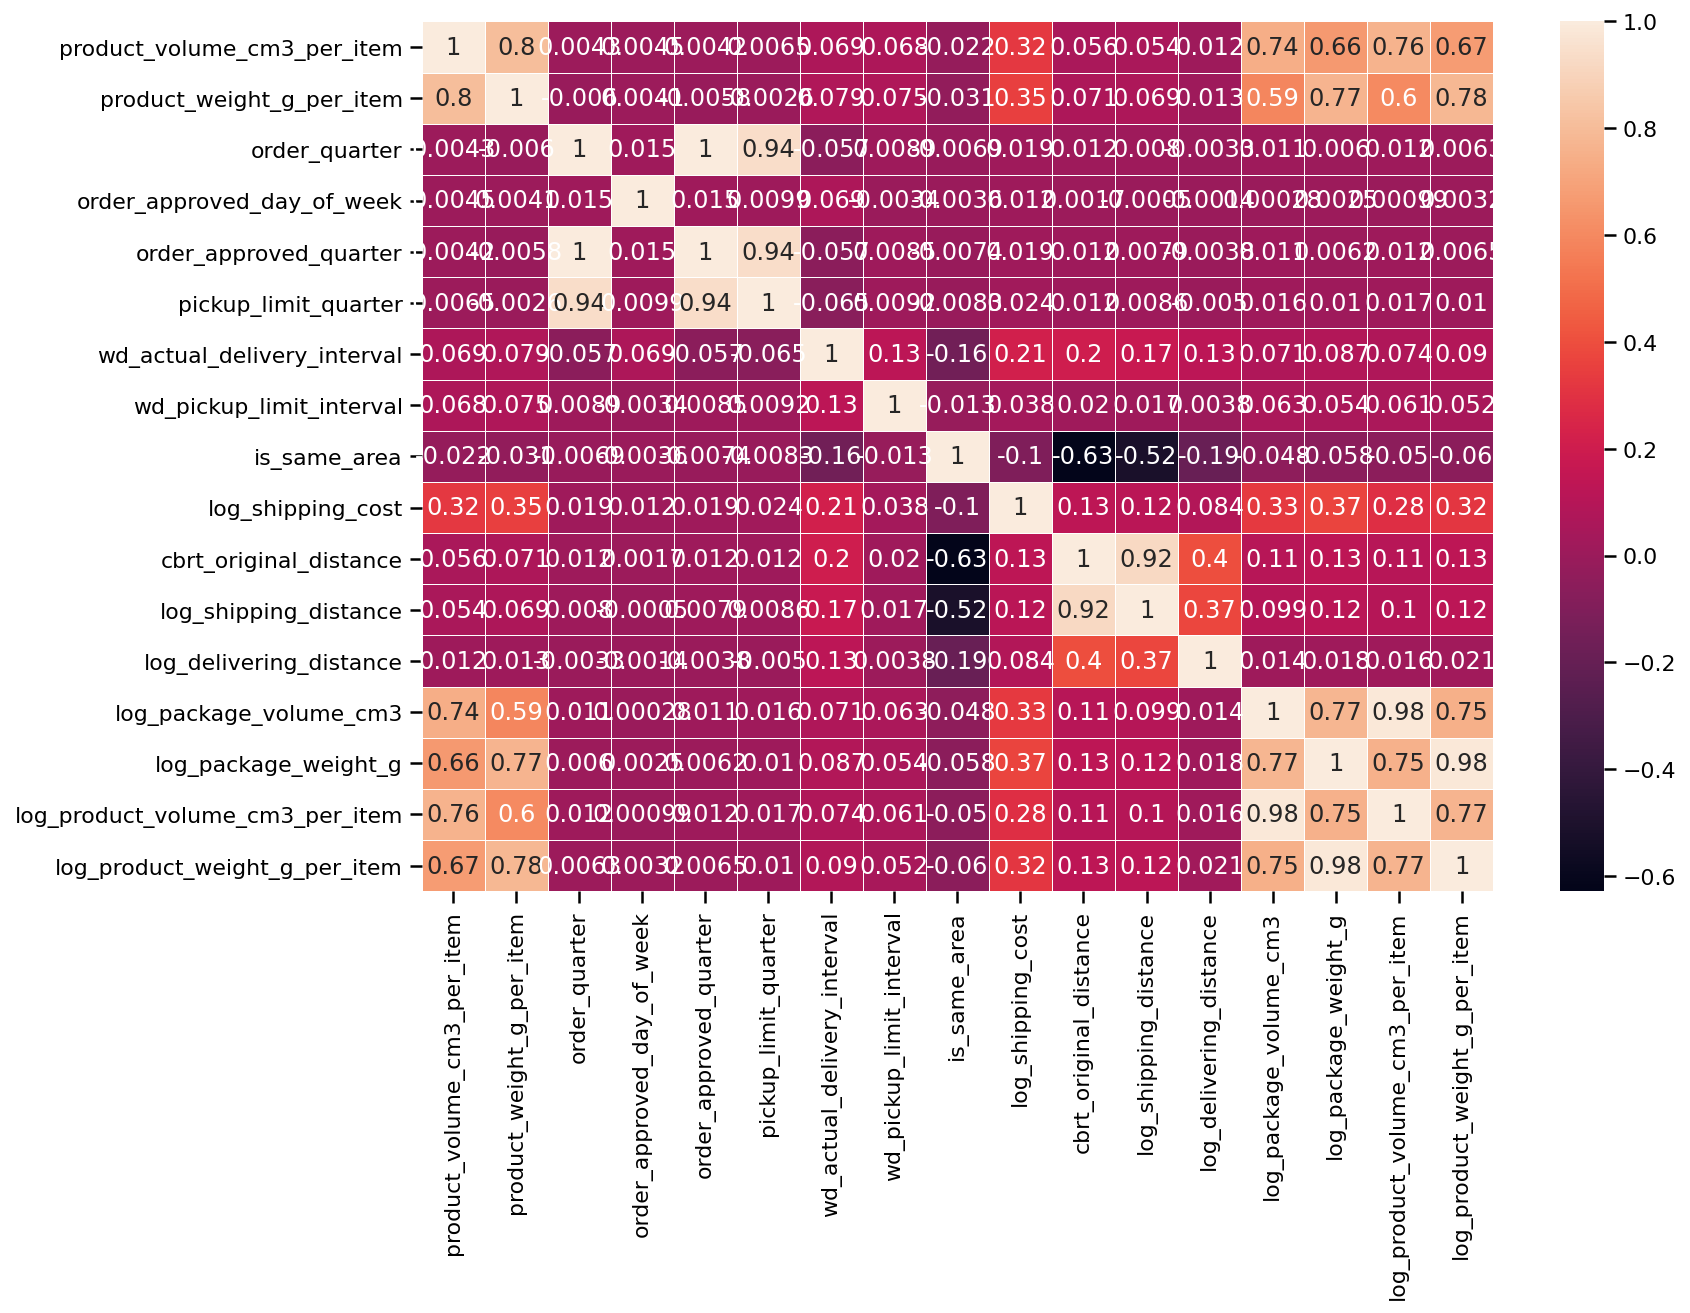

In [13]:
corr = df.drop(to_drop, axis = 1).corr()
lowerlimit = 0.05 # limit the correlation
upperlimit = 0.8
m = ~(corr.mask(np.eye(len(corr), dtype=bool)).abs()[target] < lowerlimit) & ~(corr.mask(np.eye(len(corr), dtype=bool)).abs()[target] > upperlimit) &  ~(corr.mask(np.eye(len(corr), dtype=bool)).abs()[target].isna())
m[target] = True
limited = corr.loc[m]
corr_cols = [col for col in m.index if m[col]]
limited[target].to_frame().sort_values(by=target, ascending=False).style.background_gradient()


# === Multi collinearity ===
drop_cols = ['log_total_price', 'log_aov']

vif = calc_vif(df[corr_cols].drop(drop_cols + [target], axis=1))
vif.sort_values(by="VIF", ascending=False).style.background_gradient()

plt.figure(figsize=(12,8))
sns.heatmap(df[corr_cols].drop(drop_cols, axis=1).corr(), linewidth=.5,annot=True)

## Data Preparation

In [74]:
cols = df[corr_cols + ["wd_estimated_delivery_interval"]].drop(drop_cols, axis=1).columns
numerical = ["log_aov", "log_shipping_cost", "wd_pickup_limit_interval", "log_package_weight_g", "product_weight_g_per_item", "cbrt_original_distance"]
categorical = ["is_same_area"]

df_model = df[numerical + categorical + [target] + to_drop]

In [75]:
# === Feature Scaling ===
# Scaling & Normalization
df_model = scale(df_model, numerical, StandardScaler())
df_model.head()

Processing : cbrt_original_distance: 100%|██████████████████████████████████████████████| 6/6 [00:00<00:00, 137.30it/s]


,log_aov,log_shipping_cost,wd_pickup_limit_interval,log_package_weight_g,product_weight_g_per_item,cbrt_original_distance,is_same_area,wd_actual_delivery_interval,wd_estimated_delivery_interval
0,-1.477596,-0.506764,-0.456246,-1.075655,-0.504295,-0.095227,0,8,25
1,0.690181,-0.528018,-0.019481,0.628447,-0.016540,-0.192807,0,9,9
2,-0.391741,-0.555103,-0.456246,-0.005552,-0.328161,0.382283,0,2,21
3,0.675547,-0.882579,-0.237864,-0.447360,-0.431674,-0.154112,0,7,11
4,0.381539,0.450621,-0.019481,0.793839,0.118948,-0.409450,0,15,28


In [76]:
# === One Hot encoding ===
df_model, _ = one_hot(df_model, categorical)
df_model.head()

,log_aov,log_shipping_cost,wd_pickup_limit_interval,log_package_weight_g,product_weight_g_per_item,cbrt_original_distance,is_same_area,wd_actual_delivery_interval,wd_estimated_delivery_interval,is_same_area_0,is_same_area_1
0,-1.477596,-0.506764,-0.456246,-1.075655,-0.504295,-0.095227,0,8,25,1,0
1,0.690181,-0.528018,-0.019481,0.628447,-0.016540,-0.192807,0,9,9,1,0
2,-0.391741,-0.555103,-0.456246,-0.005552,-0.328161,0.382283,0,2,21,1,0
3,0.675547,-0.882579,-0.237864,-0.447360,-0.431674,-0.154112,0,7,11,1,0
4,0.381539,0.450621,-0.019481,0.793839,0.118948,-0.409450,0,15,28,1,0


In [77]:
# == Remove previous encoded cols ==
df_model = df_model.drop(categorical, axis = 1)

In [78]:
X = df_model.drop([target], axis = 1)
y = df_model[target]

detector="wd_estimated_delivery_interval"

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

baseline_pred = X_test[detector].values

# === Removing the detector cols ===
X_train = X_train.drop([detector], axis = 1)
X_test = X_test.drop([detector], axis = 1)

✔️ Baseline (naive regression)

In [79]:
def evaluate_model(true, predicted):  
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    mpd = metrics.mean_poisson_deviance(true, predicted)
    print('MAE:', mae)
    print('MSE:', mse)
    print('RMSE:', rmse)
    print('MPD:', mpd)
    print('__________________________________')
    return mae, mse, rmse, mpd 

def evaluate(true, predicted):
    mae = metrics.mean_absolute_error(true, predicted)
    mse = metrics.mean_squared_error(true, predicted)
    rmse = np.sqrt(metrics.mean_squared_error(true, predicted))
    mpd = metrics.mean_poisson_deviance(true, predicted)
    return mae, mse, rmse, mpd

In [80]:
mae,mse,rmse,mpd = evaluate_model(y_test, baseline_pred)

MAE: 13.210899817042746
MSE: 230.0736818761435
RMSE: 15.168179913099115
MPD: 11.664927971064099
__________________________________


<AxesSubplot:xlabel='wd_actual_delivery_interval'>

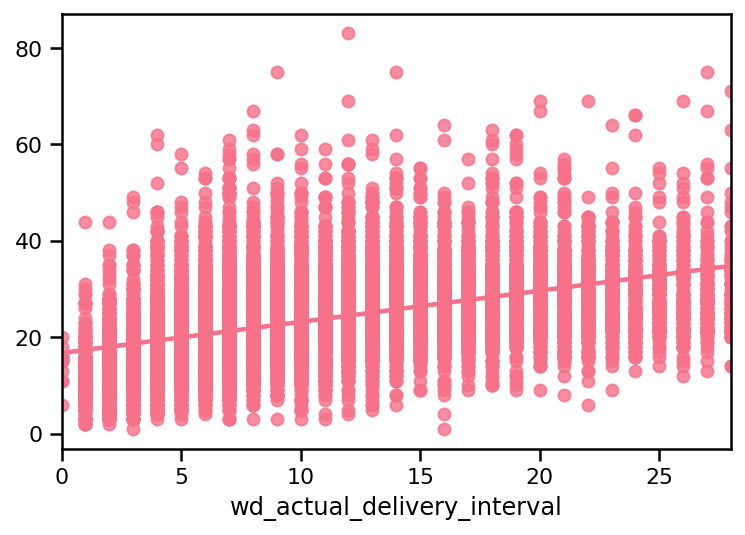

In [81]:
sns.regplot(y_test, baseline_pred)

In [82]:
# === Setting up the result dataframe (from baseline)=== 
results_df = pd.DataFrame(data=[["Baseline (Naive)", mae, mse, rmse, mpd]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', "MPD"])

# results_df = results_df.append(results_df_2, ignore_index=True)
results_df.style.highlight_max(color='red', axis = 0).highlight_min(color = 'lightgreen', axis = 0)

,Model,MAE,MSE,RMSE,MPD
0,Baseline (Naive),13.210900,230.073682,15.168180,11.664928


✔️ Linear Regression

In [83]:
lin_reg =  PoissonRegressor(alpha=1e-12, max_iter=1000)
lin_reg.fit(X_train,y_train)

PoissonRegressor(alpha=1e-12, max_iter=300)

In [84]:
coeff_df = pd.DataFrame(lin_reg.coef_, X_train.columns, columns=['Coefficient'])
coeff_df.style.background_gradient()

,Coefficient
log_aov,0.022160
log_shipping_cost,0.163566
wd_pickup_limit_interval,0.011615
log_package_weight_g,-0.033742
product_weight_g_per_item,-0.005264
cbrt_original_distance,0.083877
is_same_area_0,0.031689
is_same_area_1,-0.069036


In [85]:
test_pred = lin_reg.predict(X_test)
train_pred = lin_reg.predict(X_train)

print('Test set evaluation:\n_____________________________________')
mae, mse, rmse, mpd = evaluate_model(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
_, _, _, _ = evaluate_model(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 4.560552021934355
MSE: 32.73720472354468
RMSE: 5.721643533421553
MPD: 3.1153364999085493
__________________________________
Train set evaluation:
_____________________________________
MAE: 4.555127415370924
MSE: 33.22191540538047
RMSE: 5.7638455396879325
MPD: 3.122995803138741
__________________________________


<AxesSubplot:xlabel='wd_actual_delivery_interval'>

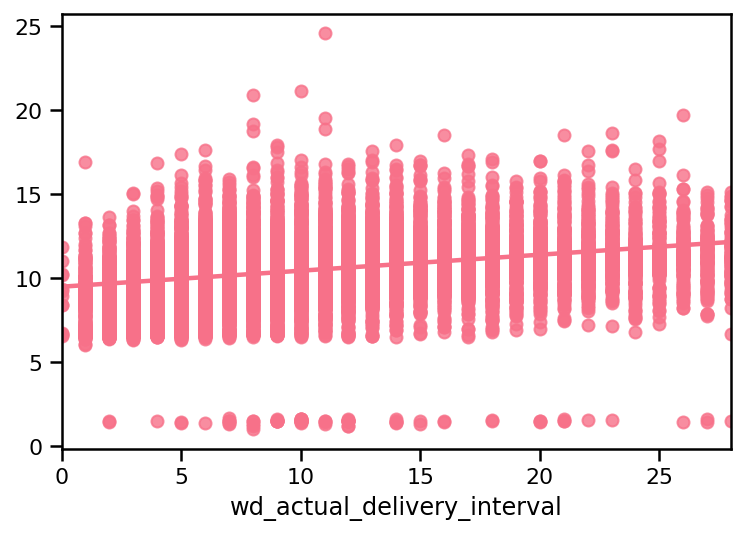

In [86]:
sns.regplot(y_test, test_pred)

In [30]:
# === Appending result to current data
results_df_linreg = pd.DataFrame(data=[["Poisson Regression", mae, mse, rmse, mpd]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', "MPD"])

results_df = results_df.append(results_df_linreg, ignore_index=True)
results_df.style.highlight_max(color='red', axis = 0).highlight_min(color = 'lightgreen', axis = 0)

,Model,MAE,MSE,RMSE,MPD
0,Baseline (Naive),13.398790,237.168762,15.400284,11.971099
1,Poisson Regression,4.533085,32.330388,5.685982,3.094156


✔️ Robust Regression

In [31]:
model = RANSACRegressor(base_estimator=PoissonRegressor(alpha=1e-12, max_iter=300), max_trials=100)
model.fit(X_train,y_train)

RANSACRegressor(base_estimator=PoissonRegressor(alpha=1e-12, max_iter=300))

In [32]:
test_pred = model.predict(X_test)
train_pred = model.predict(X_train)

print('Test set evaluation:\n_____________________________________')
mae, mse, rmse, mpd = evaluate_model(y_test, test_pred)
print('Train set evaluation:\n_____________________________________')
_, _, _, _ = evaluate_model(y_train, train_pred)

Test set evaluation:
_____________________________________
MAE: 5.436701708230915
MSE: 52.74858696443818
RMSE: 7.262822245135714
MPD: 5.971813220788314
__________________________________
Train set evaluation:
_____________________________________
MAE: 5.45471823401329
MSE: 59.48052149307769
RMSE: 7.712361602847579
MPD: 6.03250572043885
__________________________________


<AxesSubplot:xlabel='wd_actual_delivery_interval'>

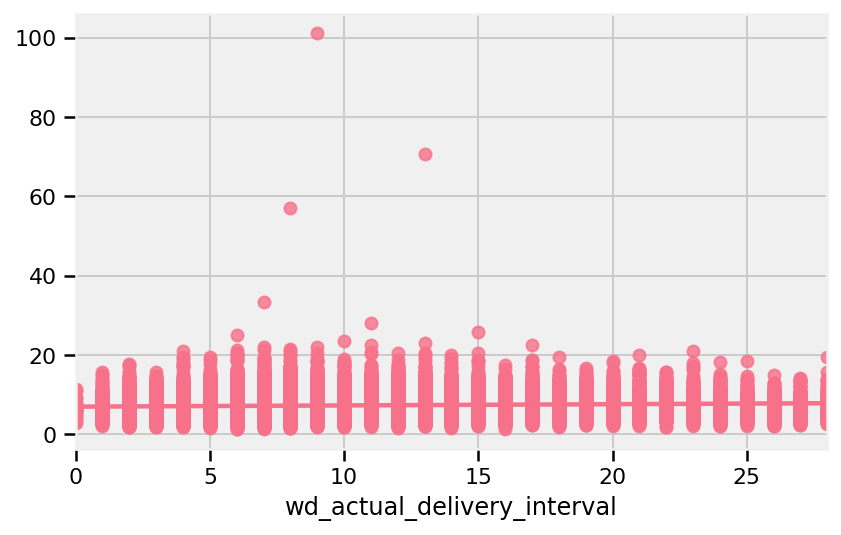

In [33]:
sns.regplot(y_test, test_pred)

In [34]:
# === Appending result to current data
results_df_robreg = pd.DataFrame(data=[["Robust Regression", mae, mse, rmse, mpd]], 
                          columns=['Model', 'MAE', 'MSE', 'RMSE', "MPD"])

results_df = results_df.append(results_df_robreg, ignore_index=True)
results_df.style.highlight_max(color='red', axis = 0).highlight_min(color = 'lightgreen', axis = 0)

,Model,MAE,MSE,RMSE,MPD
0,Baseline (Naive),13.398790,237.168762,15.400284,11.971099
1,Poisson Regression,4.533085,32.330388,5.685982,3.094156
2,Robust Regression,5.436702,52.748587,7.262822,5.971813
